## Time Series Experiments

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline

from fbprophet import Prophet

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [2]:
# We want to predict a year ahead (unit=day)
PRED_PERIODS = 360

In [3]:
# Data is daily temperature in london
CSV_DATA = "../_datasets/city_temp_00_19.csv"

In [4]:
# Temporary: See what prediction is like with clean data
# Overwrite temp data with sin-wave
# Try setting this to False and re-running
use_sin_instead_of_messy_real_data = False

In [5]:
def plot_results(pred, truth):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    ax.plot(truth, label='Truth')
    plt.plot(pred, label='Predictions')
    plt.legend()
    plt.show()

In [6]:
# Daily data from 2012 to 2017
big_frame = pd.read_csv(CSV_DATA)
big_frame.rename(columns={
    'YEARMODA':'ds',
    'temperature_c':'y'}, inplace=True)
big_frame.head()

,ds,y
0,2000-01-01,9.500000
1,2000-01-02,9.500000
2,2000-01-03,9.444444
3,2000-01-04,6.277778
4,2000-01-05,8.055556


In [7]:
big_frame.index = big_frame.ds
print(big_frame.shape)
big_frame.head()

(6309, 2)


,ds,y
ds,,
2000-01-01,2000-01-01,9.500000
2000-01-02,2000-01-02,9.500000
2000-01-03,2000-01-03,9.444444
2000-01-04,2000-01-04,6.277778
2000-01-05,2000-01-05,8.055556


In [8]:
if use_sin_instead_of_messy_real_data:
    big_frame['y'] = np.sin(np.linspace(0, 300, len(big_frame)), dtype=np.float32)

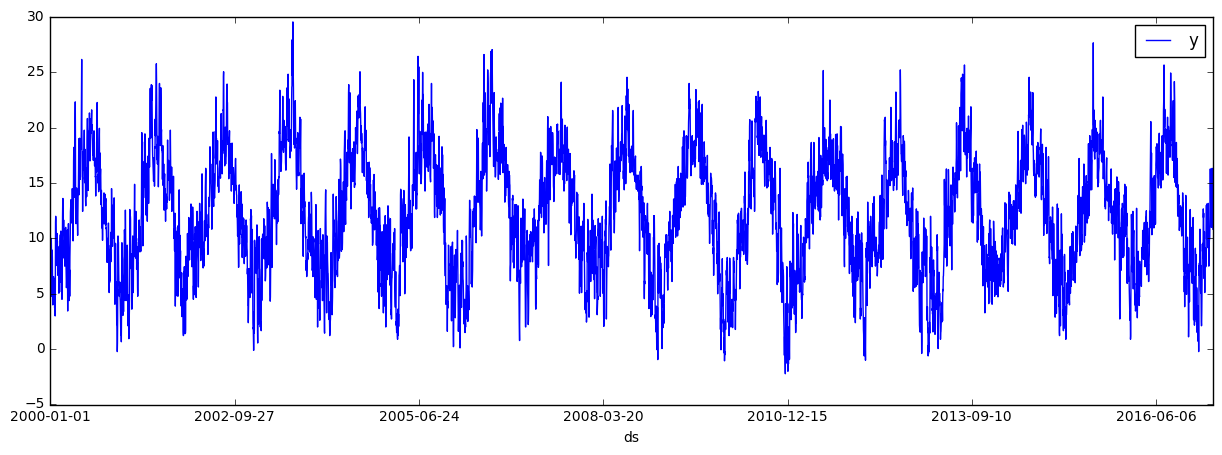

In [9]:
big_frame.plot(figsize=(15,5))

In [10]:
# Split into test and training
fb_train = big_frame[:len(big_frame)-PRED_PERIODS]
fb_test = big_frame[len(big_frame)-PRED_PERIODS:]

5949


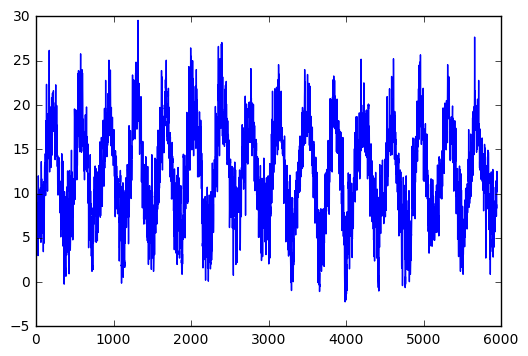

In [11]:
print(len(fb_train))
plt.plot(fb_train.y.values)

360


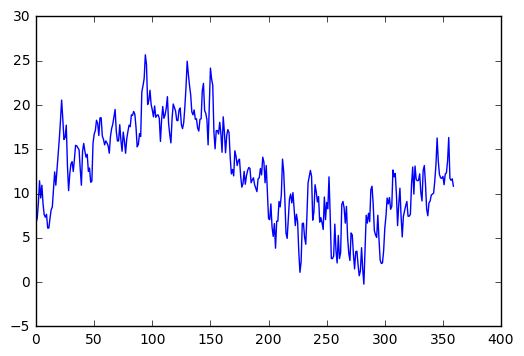

In [12]:
print(len(fb_test))
plt.plot(fb_test.y.values)

## Method 1 - Prophet

In [13]:
m = Prophet()
m.fit(fb_train)

In [14]:
future = m.make_future_dataframe(periods=PRED_PERIODS)
forecast = m.predict(future)

In [15]:
plot_guess = forecast[-PRED_PERIODS:]['yhat'].values
plot_truth = fb_test['y'].values

### Result 1: Prophet prediction for a year ahead

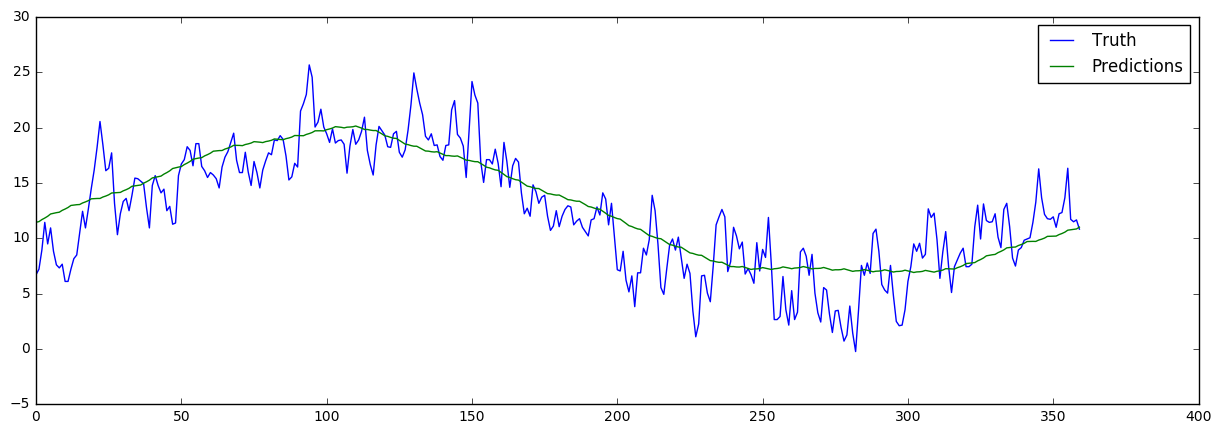

In [16]:
plot_results(plot_guess, plot_truth)

In [17]:
# Mean-Squared Error
sum((plot_guess-plot_truth)**2)/len(plot_guess)

8.1665562659022743

In [18]:
forecast.head()

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat
0,2000-01-01,0.000000,12.101232,-5.530113,-5.530113,12.101232,12.101232,3.082513,10.152913,-0.017675,-0.017675,-0.017675,-5.512437,-5.512437,-5.512437,-5.530113,6.571119
1,2000-01-02,0.000168,12.101484,-5.596272,-5.596272,12.101484,12.101484,3.082891,9.842826,-0.089418,-0.089418,-0.089418,-5.506854,-5.506854,-5.506854,-5.596272,6.505212
2,2000-01-03,0.000336,12.101735,-5.536892,-5.536892,12.101735,12.101735,3.015339,9.742707,-0.033442,-0.033442,-0.033442,-5.503449,-5.503449,-5.503449,-5.536892,6.564843
3,2000-01-04,0.000504,12.101986,-5.521886,-5.521886,12.101986,12.101986,3.226346,10.148226,-0.019431,-0.019431,-0.019431,-5.502454,-5.502454,-5.502454,-5.521886,6.580101
4,2000-01-05,0.000672,12.102238,-5.488124,-5.488124,12.102238,12.102238,3.140725,10.243598,0.015891,0.015891,0.015891,-5.504015,-5.504015,-5.504015,-5.488124,6.614114


## Method 2 - LSTM (predict based on prev prediction; one-by-one)

5949


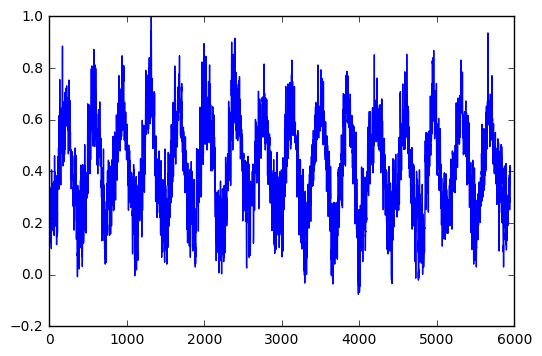

In [19]:
data = fb_train.y.values

# Scale to 0-1 range
scaled_by = max(data)
data = data/scaled_by

print(len(data))
plt.plot(data)

In [20]:
def load_data(data, seq_len):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    x_train = result[:, :-1]
    y_train = result[:, -1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    return [x_train, y_train]

In [21]:
def create_model(layers):
    model = Sequential()
    
    model.add(LSTM(
        input_shape=(None, layers[0]),
        units=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        units=layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=layers[-1]))
    # Regression output
    model.add(Activation("linear"))

    optimizer = RMSprop()
    model.compile(loss='mse', optimizer=optimizer)
    return model

5448


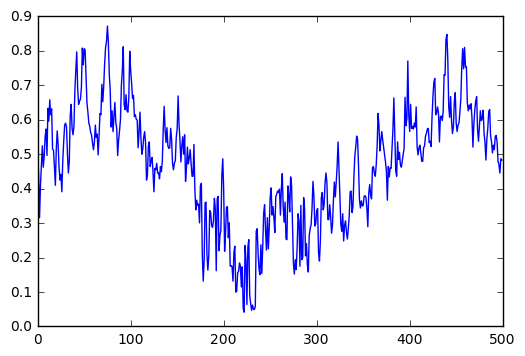

In [34]:
# Window-span
seq_len = 500
X_train, y_train = load_data(data, seq_len)
print(len(X_train))
plt.plot(y_train[:seq_len])

In [35]:
print(X_train.shape)
print(y_train.shape)

(5448, 500, 1)
(5448,)


In [44]:
# Build
model = create_model([1, 50, 150, 1])

# Fit
model.fit(
    X_train,
    y_train,
    batch_size=500,
    epochs=50,
    validation_split=0.1)

Train on 4903 samples, validate on 545 samples
Epoch 1/50
4903/4903 [==============================] - 155s - loss: 0.0514 - val_loss: 0.0081
Epoch 2/50
4903/4903 [==============================] - 165s - loss: 0.0103 - val_loss: 0.0078
Epoch 3/50
4903/4903 [==============================] - 165s - loss: 0.0122 - val_loss: 0.0328
Epoch 4/50
4903/4903 [==============================] - 165s - loss: 0.0141 - val_loss: 0.0085
Epoch 5/50
4903/4903 [==============================] - 167s - loss: 0.0130 - val_loss: 0.0077
Epoch 6/50
4903/4903 [==============================] - 165s - loss: 0.0122 - val_loss: 0.0088
Epoch 7/50
4903/4903 [==============================] - 168s - loss: 0.0121 - val_loss: 0.0082
Epoch 8/50
4903/4903 [==============================] - 165s - loss: 0.0112 - val_loss: 0.0078
Epoch 9/50
4903/4903 [==============================] - 167s - loss: 0.0104 - val_loss: 0.0084
Epoch 10/50
4903/4903 [==============================] - 165s - loss: 0.0106 - val_loss: 0.0093
Ep

In [45]:
def make_forward_predictions(model, X_input, pred_for, seq_len):
    """ Recursively predict using previous prediction """
    predictions = np.zeros(pred_for)
    for i in range(pred_for):
        pred_rs = X_input.reshape(1, X_input.shape[0], 1)
        pred = model.predict(pred_rs)
        predictions[i] = pred[0][0]
        X_input = np.concatenate((X_input[1:seq_len], pred[0]))
    return predictions

In [46]:
# Take last X-value to init
X_train_in = big_frame.y.values[-PRED_PERIODS-seq_len:]/scaled_by

# Check we match-up
# Next value to predict would be:
print(X_train_in[:seq_len+1][-1]*scaled_by)
# Start of test data:
print(plot_truth[0])

# Give data before test
X_train_in = X_train_in[:seq_len+0]

6.72222222222
6.72222222222


In [47]:
# E.g. first prediction
model.predict(X_train_in.reshape(1, X_train_in.shape[0], 1)) * scaled_by

array([[ 10.56823349]], dtype=float32)

In [48]:
# First Truth:
plot_truth[0]

6.7222222222222223

In [49]:
%%time
# Recursively predict truths now
predicted = make_forward_predictions(model, X_train_in, PRED_PERIODS, seq_len) * scaled_by

CPU times: user 1min 41s, sys: 1min, total: 2min 41s
Wall time: 38 s


In [50]:
print(predicted[:10])

[ 10.56823351  10.56163173  10.63747686  10.7225451   10.79976167
  10.86488012  10.91982418  10.96822635  11.01325056  11.05693063]


In [51]:
print(plot_truth[:10])

[  6.72222222   7.22222222   8.94444444  11.44444444   9.5         10.94444444
   8.83333333   7.61111111   7.33333333   7.66666667]


### Result 2: LSTM prediction for a year ahead (recursive)

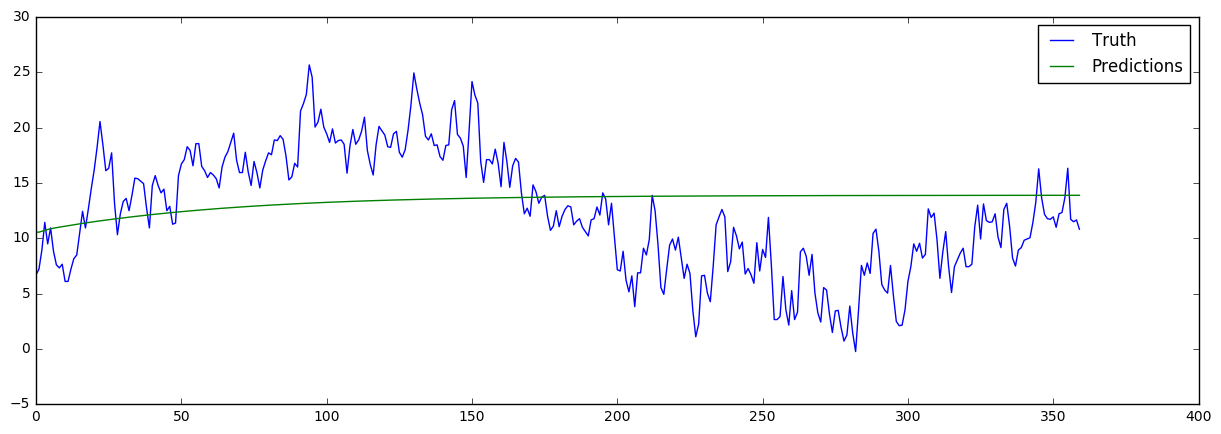

In [52]:
plot_results(predicted, plot_truth)

In [53]:
sum((predicted-plot_truth)**2)/len(predicted)

32.90014968436688

## Method 3 - LSTM (predict in one go)

In [54]:
def load_data_mult(data, seq_len, pred_forward):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length - pred_forward):
        result.append(data[index: index + sequence_length + pred_forward])
    result = np.array(result)
    x_train = result[:, :-pred_forward-1]
    y_train = result[:, -pred_forward-1:-1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    return [x_train, y_train]

In [55]:
X_train, y_train = load_data_mult(data, seq_len, PRED_PERIODS)

In [56]:
print(X_train.shape)
print(y_train.shape)

(5088, 500, 1)
(5088, 360)


In [57]:
# Build
model = create_model([1, 50, 150, y_train.shape[-1]])

# Fit
model.fit(
    X_train,
    y_train,
    batch_size=500,
    epochs=50,
    validation_split=0.1)

Train on 4579 samples, validate on 509 samples
Epoch 1/50
4579/4579 [==============================] - 87s - loss: 0.1217 - val_loss: 0.0341
Epoch 2/50
4579/4579 [==============================] - 70s - loss: 0.0466 - val_loss: 0.0301
Epoch 3/50
4579/4579 [==============================] - 91s - loss: 0.0428 - val_loss: 0.0295
Epoch 4/50
4579/4579 [==============================] - 73s - loss: 0.0409 - val_loss: 0.0280
Epoch 5/50
4579/4579 [==============================] - 71s - loss: 0.0396 - val_loss: 0.0263
Epoch 6/50
4579/4579 [==============================] - 69s - loss: 0.0376 - val_loss: 0.0232
Epoch 7/50
4579/4579 [==============================] - 65s - loss: 0.0305 - val_loss: 0.0253
Epoch 8/50
4579/4579 [==============================] - 62s - loss: 0.0312 - val_loss: 0.0229
Epoch 9/50
4579/4579 [==============================] - 60s - loss: 0.0291 - val_loss: 0.0264
Epoch 10/50
4579/4579 [==============================] - 60s - loss: 0.0305 - val_loss: 0.0189
Epoch 11/50


In [58]:
%%time
# Take last X-value to init
X_train_in = big_frame.y.values[-PRED_PERIODS-seq_len:]/scaled_by
# Give data before test
X_train_in = X_train_in[:seq_len+0]

predicted = model.predict(X_train_in.reshape(1, X_train_in.shape[0], 1))[0] * scaled_by

CPU times: user 559 ms, sys: 270 ms, total: 830 ms
Wall time: 480 ms


In [59]:
print(predicted[:10])

[  9.64346504   9.50061417   9.83162212  10.02169418  10.06107998
  10.23025417  10.31728172  10.42567635  10.35508347  10.50945473]


In [60]:
print(plot_truth[:10])

[  6.72222222   7.22222222   8.94444444  11.44444444   9.5         10.94444444
   8.83333333   7.61111111   7.33333333   7.66666667]


### Result 3: LSTM prediction for a year ahead (one-step)

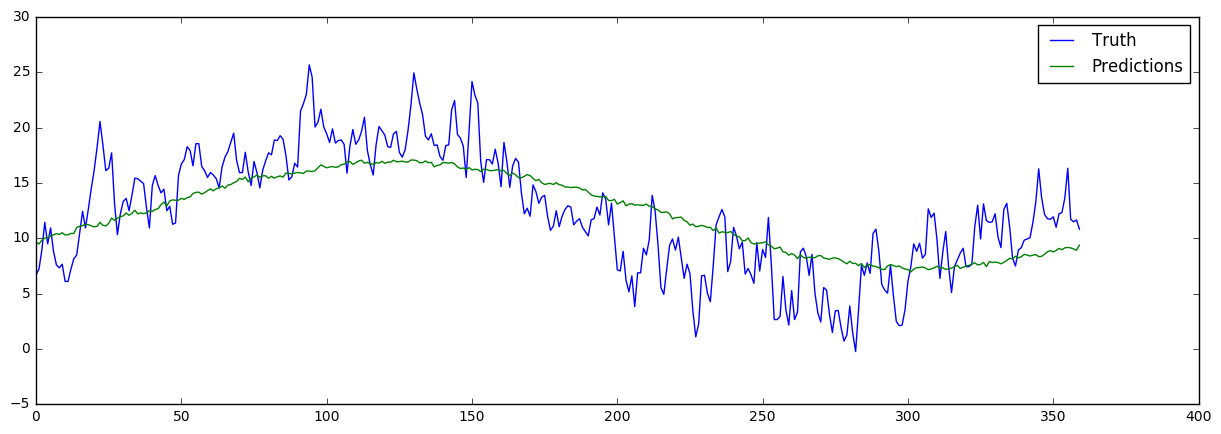

In [61]:
plot_results(predicted, plot_truth)

In [62]:
sum((predicted-plot_truth)**2)/len(predicted)

12.650355786413893